In [1]:
import Pkg
Pkg.add("Revise")
Pkg.add("IonSim")
Pkg.add("QuantumOptics")
using Revise
using IonSim
using QuantumOptics: timeevolution, stochastic, Basis
Pkg.add("StochasticDiffEq")
Pkg.add("DSP")

    Updating registry at `C:\Users\jewoo\.julia\registries\General.toml`
   Resolving package versions...
  No Changes to `C:\Users\jewoo\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\jewoo\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\jewoo\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\jewoo\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\jewoo\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\jewoo\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\jewoo\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\jewoo\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\jewoo\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\jewoo\.julia\environments\v1.10\Manifest.toml`


In [18]:
# 1. Import necessary libraries
using IonSim
using QuantumOptics
using PyPlot # Using PyPlot for plotting, as it interfaces with Python's Matplotlib

# 2. Define the Physical System
# Define the ion species and the energy levels for the qubit
# We'll use Calcium-40, with the qubit encoded in the S1/2 and D5/2 levels.
C = Ca40([("S1/2", -1/2, "g"),("D5/2", -1/2, "e")])
# Create aliases for the qubit states for easier access
#set_sublevel_alias!(C, Dict("g" => ("S1/2", -1/2), "e" => ("D5/2", -1/2)))

# Define the trap configuration. We'll model a single ion in a linear chain
# with a 1 MHz axial motional frequency.
chain = LinearChain(
    ions=[C],
    comfrequencies=(x=3e6, y=3e6, z=1e6),
    selectedmodes=(;z=[1]) # We only consider the axial mode of motion
)

# Define the laser that will drive the transition
L = Laser()

# Combine all components into a single Trap object, which represents the full experiment
# This is the main object that holds the entire state of our physical system.
T = Chamber(
    iontrap=chain,
    B=4e-4,              # Magnetic field in Tesla
    Bhat=ẑ,              # Magnetic field direction
    lasers=[L]
)

# 3. Define Experiment and Pulse Parameters
# Set the laser properties. The Pulse(T, w, I, phi, t) parameters from your
# request are set here as properties of the laser object.
# 'w' (frequency) is set by Δ (detuning) and λ (wavelength).
# 'I' (intensity) is set by E (E-field amplitude).
# 'phi' is set by L.ϕ.
# 't' (time-dependence) is handled by the solver over a time span `tspan`.
L.k = (x̂ + ẑ)/√2       # Laser wavevector
L.ϵ = (x̂ - ẑ)/√2       # Laser polarization
L.λ = transitionwavelength(C, ("g", "e"), T) # Set laser wavelength to be resonant with the transition

# For a carrier transition, we set the detuning to zero.
L.Δ = 0.0

# Set the laser intensity by defining the electric field amplitude.
# A convenient way to do this is to specify the desired "pi-time" (the time
# for a full population flop from |g> to |e>). Let's aim for a 2.5 µs pi-time.
# This corresponds to a Rabi Frequency of Ω = π / (2.5e-6) = (2π) * 200 kHz.
pi_time = 2.5e-6
E_amplitude = 1000000 #Efield_from_pi_time(pi_time, T, 1, 1, ("g", "e"))
intensity!(L, t->E_amplitude) # This sets a constant (square) pulse


#11 (generic function with 1 method)

In [16]:

# 4. Construct Hamiltonian and Run Simulation
# Set the Hilbert space dimension for the motional mode (max number of phonons)
mode = zmodes(T)[1]
#mode.N = 10

# Construct the time-independent Hamiltonian for the system
# For a simple square pulse, the Hamiltonian is not time-dependent.
# We set a high rwa_cutoff to ensure all terms are included.
H = hamiltonian(T, rwa_cutoff=Inf)



(::IonSim.var"#f#150"{Operator{CompositeBasis{Vector{Int64}, Tuple{IonInstance{:Ca40}, VibrationalMode}}, CompositeBasis{Vector{Int64}, Tuple{IonInstance{:Ca40}, VibrationalMode}}, SparseArrays.SparseMatrixCSC{ComplexF64, Int64}}, Vector{FunctionWrappers.FunctionWrapper}, Vector{Vector{Vector{Int64}}}, FunctionWrappers.FunctionWrapper{Float64, Tuple{Float64}}, Vector{Float64}, Vector{Vector{Int64}}, Vector{Int64}, Vector{Vector{Tuple{Int64, Int64}}}, Vector{Vector{Tuple{Int64, Int64}}}, Vector{FunctionWrappers.FunctionWrapper}}) (generic function with 1 method)

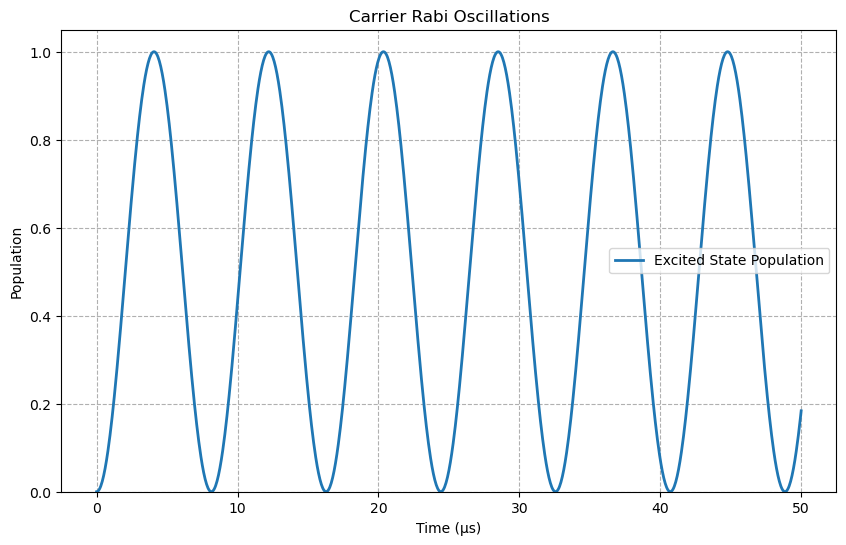

In [20]:
# Define the initial state: ion in the ground state |g⟩ and motional mode in
# the ground state |0⟩.
ψ_mode = fockstate(mode[1].basis, 0)
ψ₀ = C["g"] ⊗ ψ_mode

# Define the time span for the simulation. We'll run it for two pi-times (5 µs)
# to see a full Rabi flop.
#tspan = 0:0.05e-6:5e-6

t_cal_max = 50e-6 
tspan = 0:t_cal_max/1000:t_cal_max
# Solve the time evolution using the Schrödinger equation solver from QuantumOptics.jl
tout, sol = timeevolution.schroedinger_dynamic(tspan, ψ₀, H)

# 5. Analyze and Visualize the Results
# Calculate the population in the excited state |e⟩ over time
excited_pop = expect(ionprojector(T, "e"), sol)

# Create the plot using PyPlot
figure(figsize=(10, 6))
plot(tout.* 1e6, real.(excited_pop), label="Excited State Population", color="C0", linewidth=2)
xlabel("Time (μs)")
ylabel("Population")
title("Carrier Rabi Oscillations")
ylim(0, 1.05)
grid(true, linestyle="--")
legend()
show()